# Титаник. Кто выживет?

https://www.kaggle.com/c/titanic/

In [1]:
import numpy as np
import pandas as pd

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (9, 6)

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

### Данные

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


# EDA

In [8]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [9]:
train.Sex.value_counts(dropna=False)

male      577
female    314
Name: Sex, dtype: int64

In [10]:
sns.boxplot?

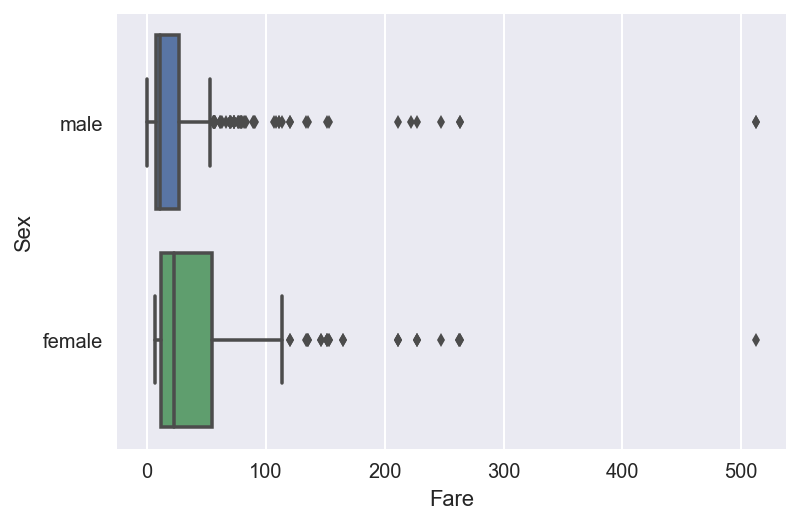

In [11]:
sns.boxplot(data=train, x='Fare', y='Sex')

In [12]:
train.groupby('Sex')['Pclass'].value_counts(normalize=True)

Sex     Pclass
female  3         0.458599
        1         0.299363
        2         0.242038
male    3         0.601386
        1         0.211438
        2         0.187175
Name: Pclass, dtype: float64

### Фичи

чтобы одинаковым образом обработать train и test и не дублировать все операции 2 раза, соединим эти два набора данных в один, не забыв при этом:
1. выкинуть целевую переменную из train
2. проверить на соответствие набора признаков друг другу
3. добавить флаг того, является ли объект тестовым или нет

In [13]:
y_train = train.Survived
train.drop('Survived', axis=1, inplace=True)

In [14]:
train.columns == test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [15]:
train['is_test'] = 0
test['is_test'] = 1

In [16]:
df = pd.concat([train, test])

супер, теперь полный набор данных можно обрабатывать вместе и в любой момент, уже обработанными, обратно разъединить на обучающую и тестовую выборки

Пол male/female закодируем в 1/0 и удалим переменные, с которыми мы не будем сейчас работать

In [17]:
#df.Sex.apply(lambda x: 1 if x=='male')

In [18]:
df["isMale"] = df.Sex.replace({"male": 1, "female":0})
df.drop(["Sex", "Cabin", "Ticket", "Name", "PassengerId"], axis=1, inplace=True)

признаки, значения которых составляют небольшой перечислимый набор, закодируем в отдельные столбцы 

In [19]:
df.Pclass.value_counts(dropna=False)

3    709
1    323
2    277
Name: Pclass, dtype: int64

In [20]:
#кодирование категориальных признаков

In [21]:
df_dummies = pd.get_dummies(df, columns=['Pclass', 'Embarked'])

In [22]:
df_dummies.head(10)

,Age,SibSp,Parch,Fare,is_test,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1
1,38.0,1,0,71.2833,0,0,1,0,0,1,0,0
2,26.0,0,0,7.9250,0,0,0,0,1,0,0,1
3,35.0,1,0,53.1000,0,0,1,0,0,0,0,1
4,35.0,0,0,8.0500,0,1,0,0,1,0,0,1
5,NaN,0,0,8.4583,0,1,0,0,1,0,1,0
6,54.0,0,0,51.8625,0,1,1,0,0,0,0,1
7,2.0,3,1,21.0750,0,1,0,0,1,0,0,1
8,27.0,0,2,11.1333,0,0,0,0,1,0,0,1
9,14.0,1,0,30.0708,0,0,0,1,0,1,0,0


In [23]:
df_dummies.isnull().sum().sort_values(ascending=False)/len(df_dummies)

Age           0.200917
Fare          0.000764
Embarked_S    0.000000
Embarked_Q    0.000000
Embarked_C    0.000000
Pclass_3      0.000000
Pclass_2      0.000000
Pclass_1      0.000000
isMale        0.000000
is_test       0.000000
Parch         0.000000
SibSp         0.000000
dtype: float64

In [24]:
train.Name.apply(lambda x: x.split(', ',1)[1].split(" ",1)[0]).value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Col.           2
Mlle.          2
Major.         2
Ms.            1
Lady.          1
the            1
Mme.           1
Don.           1
Sir.           1
Capt.          1
Jonkheer.      1
Name: Name, dtype: int64

In [25]:
X_train = df_dummies[df_dummies.is_test==0].drop('is_test', axis=1)
X_test = df_dummies[df_dummies.is_test==1].drop('is_test', axis=1)

In [26]:
columns = X_train.columns

In [27]:
X_train.head(10)

,Age,SibSp,Parch,Fare,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,22.0,1,0,7.2500,1,0,0,1,0,0,1
1,38.0,1,0,71.2833,0,1,0,0,1,0,0
2,26.0,0,0,7.9250,0,0,0,1,0,0,1
3,35.0,1,0,53.1000,0,1,0,0,0,0,1
4,35.0,0,0,8.0500,1,0,0,1,0,0,1
5,NaN,0,0,8.4583,1,0,0,1,0,1,0
6,54.0,0,0,51.8625,1,1,0,0,0,0,1
7,2.0,3,1,21.0750,1,0,0,1,0,0,1
8,27.0,0,2,11.1333,0,0,0,1,0,0,1
9,14.0,1,0,30.0708,0,0,1,0,1,0,0


### Заполнение пустых значений

заполним пустые значения средними по соответственным признакам

In [28]:
from sklearn.preprocessing import Imputer

In [29]:
imputer = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=0, copy=True)

In [30]:
imputer.fit(X_train)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)

In [31]:
X_train_imputed = imputer.transform(X_train)
X_train_imputed = pd.DataFrame(X_train_imputed, columns=columns)

In [32]:
X_train_imputed.head(10)

,Age,SibSp,Parch,Fare,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,22.000000,1.0,0.0,7.2500,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,38.000000,1.0,0.0,71.2833,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,26.000000,0.0,0.0,7.9250,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,35.000000,1.0,0.0,53.1000,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,35.000000,0.0,0.0,8.0500,1.0,0.0,0.0,1.0,0.0,0.0,1.0
5,29.699118,0.0,0.0,8.4583,1.0,0.0,0.0,1.0,0.0,1.0,0.0
6,54.000000,0.0,0.0,51.8625,1.0,1.0,0.0,0.0,0.0,0.0,1.0
7,2.000000,3.0,1.0,21.0750,1.0,0.0,0.0,1.0,0.0,0.0,1.0
8,27.000000,0.0,2.0,11.1333,0.0,0.0,0.0,1.0,0.0,0.0,1.0
9,14.000000,1.0,0.0,30.0708,0.0,0.0,1.0,0.0,1.0,0.0,0.0


### Нормировка значений

In [33]:
from sklearn.preprocessing import StandardScaler

In [34]:
scaler = StandardScaler()

In [35]:
scaler.fit(X_train_imputed)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [36]:
X_train_imputed_scaled = scaler.transform(X_train_imputed)
X_train_imputed_scaled = pd.DataFrame(X_train_imputed_scaled, columns=columns)

In [37]:
X_train_imputed_scaled.head(10)

,Age,SibSp,Parch,Fare,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,-0.592481,0.432793,-0.473674,-0.502445,0.737695,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.619306
1,0.638789,0.432793,-0.473674,0.786845,-1.355574,1.767767,-0.510152,-1.107926,2.074505,-0.307562,-1.614710
2,-0.284663,-0.474545,-0.473674,-0.488854,-1.355574,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.619306
3,0.407926,0.432793,-0.473674,0.420730,-1.355574,1.767767,-0.510152,-1.107926,-0.482043,-0.307562,0.619306
4,0.407926,-0.474545,-0.473674,-0.486337,0.737695,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.619306
5,0.000000,-0.474545,-0.473674,-0.478116,0.737695,-0.565685,-0.510152,0.902587,-0.482043,3.251373,-1.614710
6,1.870059,-0.474545,-0.473674,0.395814,0.737695,1.767767,-0.510152,-1.107926,-0.482043,-0.307562,0.619306
7,-2.131568,2.247470,0.767630,-0.224083,0.737695,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.619306
8,-0.207709,-0.474545,2.008933,-0.424256,-1.355574,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.619306
9,-1.208115,0.432793,-0.473674,-0.042956,-1.355574,-0.565685,1.960202,-1.107926,2.074505,-0.307562,-1.614710


In [38]:
X_test_imputed_scaled = scaler.transform(imputer.transform(X_test))

### Offtop: попробуем визуализировать всех пассажиров: есть ли там кластеры?
### PCA + clustering

In [39]:
from sklearn.decomposition import PCA

In [40]:
pca = PCA(n_components=2)

In [41]:
ppl = pca.fit_transform(X_train_imputed_scaled)

всего 2 фичи объясняют 41% всего разнообразия пассажиров:

In [42]:
pca.explained_variance_ratio_.sum()

0.41017554160207326

классно, видно 6 кластеров пассажиров: внутри кластера они похожи друг на друга, межу кластерами - нет:

Text(0.5,1,'Пассажиры Титаника')

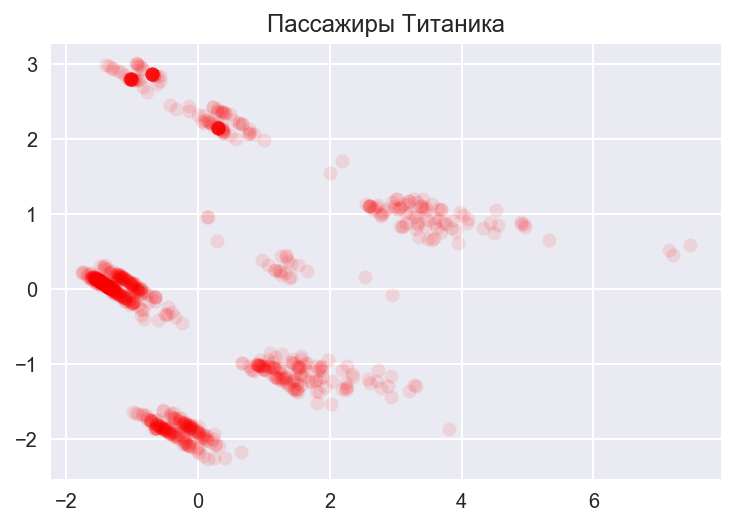

In [43]:
plt.plot(ppl[:,0], ppl[:,1], 'ro', alpha=0.1)
plt.title('Пассажиры Титаника')

можно попробовать кластеризовать по 7 кластерам и проверить, что получится:

In [44]:
from sklearn.cluster import KMeans

In [45]:
n_clusters = 7

In [46]:
kmeans = KMeans(n_clusters=n_clusters)

In [47]:
kmeans.fit(X_train_imputed_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [48]:
cluster_labels = kmeans.predict(X_train_imputed_scaled)

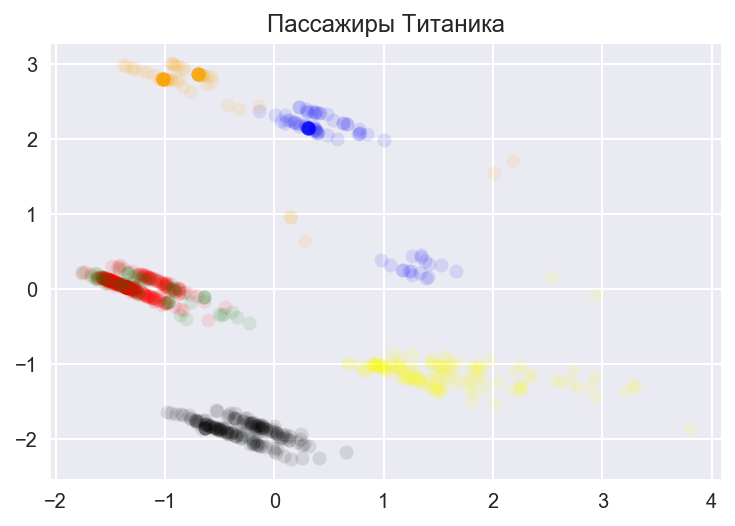

In [49]:
plt.title('Пассажиры Титаника')
for i,color in zip(range(n_clusters),{'blue','red','green','black','orange','yellow'}):
    t = ppl[cluster_labels==i]
    plt.plot(t[:,0], t[:,1], 'ro', alpha=0.1, c=color)

эти номера кластеров можно было бы подать как ещё одна фича

### Разделение на обучающую и тестирующую выборки

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
X_train_fin, X_val, y_train_fin, y_val = train_test_split(X_train_imputed_scaled, y_train, test_size=0.2)

In [52]:
X_train_fin.shape

(712, 11)

In [53]:
X_val.shape

(179, 11)

In [54]:
X_test_imputed_scaled.shape

(418, 11)

In [55]:
y_train_fin.shape

(712,)

In [56]:
y_val.shape

(179,)

### Обучение с кросс-валидацией

кросс-валидация поможет нам подобрать лучший параметр регуляризации

In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [58]:
cs = 10**np.linspace(-3,1,5)
cs

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])

In [59]:
grid = {'C': cs}
gridsearch = GridSearchCV(LogisticRegression(), grid, scoring='accuracy', cv=5)

In [60]:
%%time
gridsearch.fit(X_train_fin, y_train_fin)

CPU times: user 272 ms, sys: 9.68 ms, total: 281 ms
Wall time: 164 ms


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [61]:
sorted(gridsearch.grid_scores_, key = lambda x: -x.mean_validation_score)

/Users/lera/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.79073, std: 0.02573, params: {'C': 1.0},
 mean: 0.79073, std: 0.02573, params: {'C': 10.0},
 mean: 0.78792, std: 0.03174, params: {'C': 0.1},
 mean: 0.78652, std: 0.02931, params: {'C': 0.01},
 mean: 0.77528, std: 0.02771, params: {'C': 0.001}]

In [62]:
gridsearch.best_params_

{'C': 1.0}

In [63]:
best_C = gridsearch.best_params_["C"]

# Оценка точности

In [64]:
from sklearn.metrics import accuracy_score

In [65]:
clf = LogisticRegression(C=best_C)

In [66]:
clf.fit(X_train_fin, y_train_fin)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [67]:
y_val_pred = clf.predict(X_val)

In [68]:
accuracy_score(y_val, y_val_pred)

0.8324022346368715

# Финальное предсказание

In [69]:
clf.fit(X_train_imputed_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

предсказание вероятностей принадлежности классу 0 и 1:

In [70]:
clf.predict_proba(X_test_imputed_scaled)[:10]

array([[0.89082537, 0.10917463],
       [0.65189183, 0.34810817],
       [0.87414357, 0.12585643],
       [0.90242213, 0.09757787],
       [0.43765987, 0.56234013],
       [0.84864704, 0.15135296],
       [0.3193424 , 0.6806576 ],
       [0.79167236, 0.20832764],
       [0.22309097, 0.77690903],
       [0.9300685 , 0.0699315 ]])

предсказание номера класса:

In [71]:
predictions = clf.predict(X_test_imputed_scaled)
predictions

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [72]:
submussion = 'PassengerId,Survived\n'
submussion += "\n".join(["{},{}".format(pid, prediction) for pid, prediction in zip(test.PassengerId, predictions)])

In [73]:
with open('submission.txt', 'w') as file:
    file.write(submussion)

In [74]:
for col, val in zip(X_train.columns, clf.coef_[0]):
    print("{:30} {:.2f}".format(col, val))

Age                            -0.50
SibSp                          -0.35
Parch                          -0.08
Fare                           0.12
isMale                         -1.28
Pclass_1                       0.49
Pclass_2                       0.09
Pclass_3                       -0.49
Embarked_C                     -0.07
Embarked_Q                     -0.06
Embarked_S                     -0.28


Регрессия позволяет посмотреть влияние различных факторов на принятое решение. Так, видно, что женский пол, маленький возраст и первый класс являлись сильными предпосылками к выживанию

# Lvl 1:

взять подготовленные раннее данные из задачи Titanic, обучиться на них с помощью дерева решений и кросс-валидации и сделать сабмит
кросс-валидацию желательно сделать сразу по нескольким фичам ( параметр grid в GridSearchCV )
определить самые важные фичи
вывести дерево решений (можете попробовать установить pydot и webgraphviz для отрисовки деревьев внутри ноутбука)
Результат: скрины нового сабмита на Kaggle и построенного дерева.

Lvl 2: (опционально)

С помощью функций sklearn.metrics.auc, precision, recall составить функцию для расчёта ROC-AUC, ROC-PRC

In [75]:
X_train_fin.shape[1]

11

In [76]:
clf_tree=DecisionTreeClassifier(random_state=20)

In [77]:
cross_val_score(clf_tree, X_train_fin, y_train_fin, cv=10)

array([0.79166667, 0.59722222, 0.84507042, 0.83098592, 0.84507042,
       0.76056338, 0.74647887, 0.77464789, 0.74647887, 0.78873239])

In [78]:
np.mean(cross_val_score(clf_tree, X_train_fin, y_train_fin, cv=10))

0.7726917057902973

In [79]:
tree_grid_params={'max_depth':np.arange(1,12), 'max_features':np.arange(1,11)}

In [80]:
GridSearch=GridSearchCV(DecisionTreeClassifier(random_state=20), tree_grid_params, scoring='accuracy', cv=10)

In [81]:
% time
GridSearch.fit(X_train_fin, y_train_fin)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 11 µs


GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=20,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), 'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [82]:
GridSearch.best_params_

{'max_depth': 3, 'max_features': 8}

In [83]:
GridSearch.best_score_

0.8146067415730337

In [84]:
clf_tree_best=DecisionTreeClassifier(max_depth=3, max_features=8, random_state=20)

In [85]:
cross_val_score(clf_tree_best, X_train_fin, y_train_fin, cv=10)

array([0.81944444, 0.77777778, 0.85915493, 0.81690141, 0.81690141,
       0.8028169 , 0.83098592, 0.8028169 , 0.74647887, 0.87323944])

In [86]:
np.mean(cross_val_score(clf_tree_best, X_train_fin, y_train_fin, cv=10))

0.8146517996870111

In [87]:
clf_tree_best.fit(X_train_fin, y_train_fin)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=20, splitter='best')

([<matplotlib.axis.YTick at 0x1a1d3cf710>,
 <a list of 11 Text yticklabel objects>)

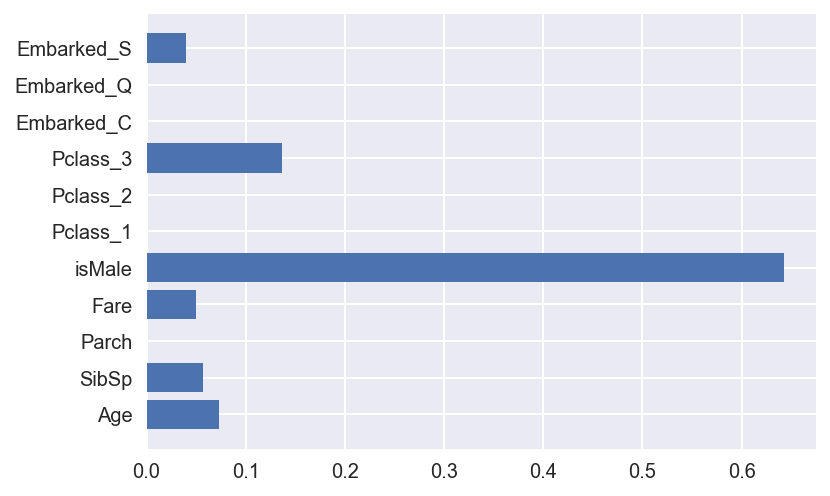

In [88]:
plt.barh(np.arange(len(clf_tree_best.feature_importances_)), clf_tree_best.feature_importances_)
plt.yticks(np.arange(len(X_train_fin.columns)),X_train_fin.columns)

In [89]:
from sklearn.tree import export_graphviz
from graphviz import Source

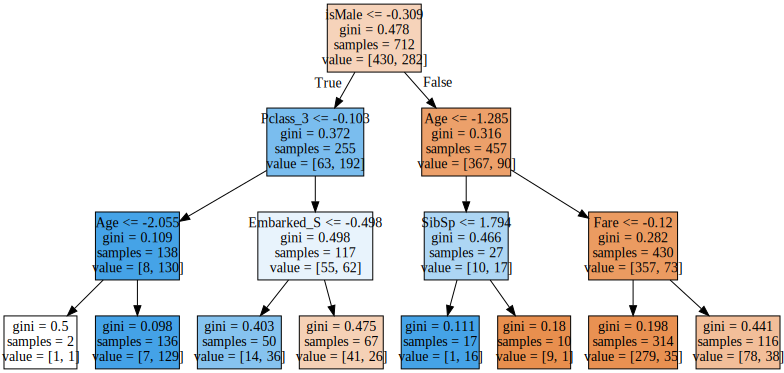

In [90]:
def get_tree_dot_view(clf, feature_names=None, class_names=None):
    return Source(export_graphviz(clf, out_file=None, filled=True, feature_names=feature_names, class_names=class_names))
get_tree_dot_view(clf_tree_best, list(X_train_fin.columns))

In [91]:
y_val_pred = clf.predict(X_val)
accuracy_score(y_val, y_val_pred)

0.8379888268156425

In [92]:
predictions = clf.predict(X_test_imputed_scaled)
predictions

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [93]:
submussion = 'PassengerId,Survived\n'
submussion += "\n".join(["{},{}".format(pid, prediction) for pid, prediction in zip(test.PassengerId, predictions)])
with open('submission.csv', 'w') as file:
    file.write(submussion)

In [94]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [95]:
def get_confusion_matrix(y, y_pred, print_matrix=False):
    # приводим это в pandas.Series и избавляемся от индекса (иначе по нему будет идти сопоставление)
    y = pd.Series(list(y))
    y_pred = pd.Series(list(y_pred))
    # рассчитываем значения
    TP=sum((y==1)&(y_pred==1))
    FP=sum((y==0)&(y_pred==1))
    FN=sum((y==1)&(y_pred==0))
    TN=sum((y==0)&(y_pred==0))
    # выводим матрицу
    if print_matrix:
        print("{:5} {:5} {:5}".format("", "y=1", "y=0"))
        print("a=1 {:5} {:5}".format(TP, FP))
        print("a=0 {:5} {:5}".format(FN, TN))
    
    return {"TP":TP, "FP":FP, "TN":TN, "FN":FN}

In [96]:
get_confusion_matrix(y_val, y_val_pred, True)

      y=1   y=0  
a=1    42    11
a=0    18   108


{'TP': 42, 'FP': 11, 'TN': 108, 'FN': 18}

In [97]:
len(y_val), len(y_val_pred)

(179, 179)

**Задание.** Написать функцию для расчёта accuracy (доли верных ответов) и сравнить со значением из sklearn.metrics

$accuracy = \frac {TP+TN}{TP+TN+FP+FN}$
 

In [98]:
def accuracy(y, y_pred):
    y = pd.Series(list(y))
    y_pred = pd.Series(list(y_pred))
    # рассчитываем значения
    TP=sum((y==1)&(y_pred==1))
    FP=sum((y==0)&(y_pred==1))
    FN=sum((y==1)&(y_pred==0))
    TN=sum((y==0)&(y_pred==0))
    acc=(TP+TN)/(TP+TN+FP+FN)
    return acc

In [99]:
accuracy(y_val, y_val_pred)

0.8379888268156425

In [100]:
accuracy_score(y_val, y_val_pred)

0.8379888268156425

**Задание.** Написать функцию для расчёта precision (точности) и сравнить со значением из sklearn.metrics

$precision = \frac {TP}{TP+FP}$

In [101]:
def precision(y, y_pred):
    y = pd.Series(list(y))
    y_pred = pd.Series(list(y_pred))
    # рассчитываем значения
    TP=sum((y==1)&(y_pred==1))
    FP=sum((y==0)&(y_pred==1))
    FN=sum((y==1)&(y_pred==0))
    TN=sum((y==0)&(y_pred==0))
    pr=TP/(TP+FP)
    return pr
    

In [102]:
precision(y_val, y_val_pred)

0.7924528301886793

In [103]:
precision_score(y_val, y_val_pred)

0.7924528301886793

**Задание.** Написать функцию для расчёта recall (полноты) и сравнить со значением из sklearn.metrics

$recall = \frac {TP}{TP+FN}$

In [104]:
def recall(y, y_pred):
    y = pd.Series(list(y))
    y_pred = pd.Series(list(y_pred))
    # рассчитываем значения
    TP=sum((y==1)&(y_pred==1))
    FP=sum((y==0)&(y_pred==1))
    FN=sum((y==1)&(y_pred==0))
    TN=sum((y==0)&(y_pred==0))
    re=TP/(TP+FN)
    return re

In [105]:
recall(y_val, y_val_pred)

0.7

In [106]:
recall_score(y_val, y_val_pred)

0.7

$TPR = \frac {TP}{TP+FN}$ = recall

$FPR = \frac {FP}{FP+TN}$

In [107]:
def FPR(y, y_pred):
    y = pd.Series(list(y))
    y_pred = pd.Series(list(y_pred))
    # рассчитываем значения
    TP=sum((y==1)&(y_pred==1))
    FP=sum((y==0)&(y_pred==1))
    FN=sum((y==1)&(y_pred==0))
    TN=sum((y==0)&(y_pred==0))
    fpr=FP/(FP+TN)
    return fpr

In [108]:
FPR(y_val, y_val_pred)

0.09243697478991597